## Simplified graph with one lock
In this notebook, we set up a basic simulation where a vessel moves over a 1D network path that contains sequence of locks. 

We take the following steps:

1. [Imports](#1.-Imports)
    * [Initialise environment](#Initialise-environment)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
    * [Add hydrodynamic data](#3.1.-Add-hydrodynamic-data)
    * [Add lock](#3.2.-Add-lock)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [1]:
import functools
import geopandas as gpd
import io
import logging

import networkx as nx
from shapely.geometry import Point,LineString,Polygon
from shapely.geometry.collection import GeometryCollection
from shapely.ops import transform, linemerge, split, snap

import datetime
import simpy

from opentnsim import core as core_module
from opentnsim import graph as graph_module
from opentnsim import lock as lock_module
from opentnsim import model as model_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module

import numpy as np
import pandas as pd

import folium
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import pickle
import pyproj
import requests
import yaml

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
%matplotlib inline

#### Initialise environment
For later convenience we already initialise a simpy environment, with some additional properties related to the simulation start and stop time.

In [2]:
t_start = datetime.datetime(2024, 1, 1, 0, 0, 0)

env = simpy.Environment(initial_time=t_start.timestamp())

env.epoch = t_start
env.simulation_start = t_start

### 2. Create vessel
We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. We wrap the creation of the vessel class in a function, to facilitate the generation of multiple vessels. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _SimpyObject_ -
* _HasWaitingArea_ - a place where vessels can wait before entering the lock
* _HasLineUpArea_ - a place just in front of the lock to guide vessels entering the lock chamber
* _HasLock_ - the lock chamber where vessels stay during the leveling process
* _VesselProperties_ - allows the specification of vessel properties, such as L, B and T
* _ExtraMetadata_ -
* _HasOutput_ -

In [3]:
#We create a type element that schematisizes a vessel
def create_vessel(env, name, origin, destination, vessel_type, L, B, T, H, v, arrival_time):
    Vessel = type('Vessel',(core_module.Identifiable,       #The vessel should be identifiable
                            core_module.SimpyObject,        #It should be a simpy element
                            lock_module.HasLock,            #The vessel should interact with a lock chamber
                            lock_module.HasLineUpArea,      #The vessel should interact with a line-up area
                            lock_module.HasWaitingArea,     #The vessel should interact with a waiting area
                            vessel_module.VesselProperties, #The vessel should have properties
                            vessel_module.ExtraMetadata,    #The vessel can have extra metadata
                            output_module.HasOutput,        #The vessel should have output
                           ),{})    

    node = env.FG.nodes[origin]
    geometry = node["geometry"]
    
    vessel = Vessel(
        **{
            "env": env,
            "name": name,
            "origin": origin,
            "destination": destination,
            "geometry": geometry,
            "node": origin,
            "route": nx.dijkstra_path(env.FG, origin, destination),
            "type": vessel_type,
            "L": L,
            "B": B,
            "T": T,
            "H": H,
            "v": v,
            "arrival_time": arrival_time,
        }
    )

    env.process(vessel.move())
    
    return vessel

### 3. Create graph
Next we create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (red arrows between the nodes in the plot below). We use the python package networkx to do this. 

In [4]:
#We need to create a network over which the vessels will sail
node_A = graph_module.Node(name='A',geometry=Point(0,0))
node_B = graph_module.Node(name='B',geometry=Point(1000,0))
node_C = graph_module.Node(name='C',geometry=Point(1400,0))
node_D = graph_module.Node(name='D',geometry=Point(2400,0))
edges = [(node_A,node_B),(node_B,node_C),(node_C,node_D)]

FG = graph_module.DiGraph(edges=edges,crs='EPSG:28992').graph
env.FG = nx.MultiDiGraph(FG)

#In order from ships to know where they are going we need to add an VTS to the environment
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService()

In [5]:
nodes = []
coordinates = []
labels = {}

for node in env.FG.nodes:
    nodes.append(node)
    coordinates.append([nx.get_node_attributes(env.FG, 'geometry')[node].x, nx.get_node_attributes(env.FG, 'geometry')[node].y])
    labels[node] = node
    
positions = dict(zip(nodes, coordinates))

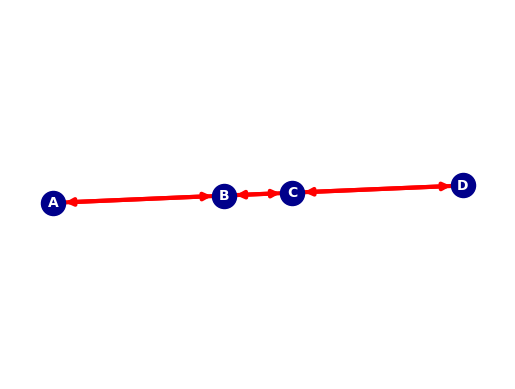

In [6]:
# draw edges, nodes and labels.
nx.draw_networkx_edges(env.FG, pos=positions, width=3, edge_color="red", alpha=1, arrowsize=10)
nx.draw_networkx_nodes(env.FG, pos=positions, node_color="darkblue", node_size=300)
nx.draw_networkx_labels(env.FG, pos=positions, labels=labels, font_size=10, font_weight="bold", font_color="white")

plt.axis("off")
plt.show()

Now we need to create the lock infrastructure

In [7]:
# #We can now add infrastructure to the network
lock_I = lock_module.IsLockComplex(env=env,
                                   name='Lock I',
                                   start_node='B',
                                   node_open='B',
                                   end_node='C',
                                   lock_length = 120,
                                   lock_width = 18,
                                   lock_depth = 6,
                                   lineup_area_A_length=120,
                                   lineup_area_B_length=120,
                                   effective_lineup_area_B_length=120,
                                   levelling_time=1500,
                                   distance_doors_A_from_waiting_area_A=140,
                                   distance_doors_B_from_waiting_area_B=140,
                                   distance_waiting_area_A_from_start_node=0,
                                   distance_waiting_area_B_from_end_node=0,
                                   distance_lineup_area_A_to_lock_doors_A=20,
                                   distance_lineup_area_B_to_lock_doors_B=0)


Now we need to add a vessel

#### 4. Run simulation

In [8]:
vessel_1 = create_vessel(env, 'Vessel_1', 'A', 'D', 'inland vessel', 100, 15, 5, 4, 3, pd.Timestamp('2024-01-01'))
vessel_2 = create_vessel(env, 'Vessel_2', 'D', 'A', 'inland vessel', 100, 15, 5, 4, 3, pd.Timestamp('2024-01-01'))
vessels = [vessel_1, vessel_2]

In [9]:
env.run()

#### 5. Inspect results

In [10]:
vessel_df = pd.DataFrame(vessel_2.log)
vessel_df

,Time,Location,Action,Status
0,2024-01-01 00:00:00.000000,POINT (3.34564653432207 47.975359744537315),Sailing from node D to node C start,"{'origin': 'D', 'destination': 'A', 'route': [..."
1,2024-01-01 00:05:32.876714,POINT (3.3322760502404094 47.97511342773499),Sailing from node D to node C stop,"{'origin': 'D', 'destination': 'A', 'route': [..."
2,2024-01-01 00:05:32.876714,POINT (3.3322760502404094 47.97511342773499),Sailing from node C to node B start,"{'origin': 'D', 'destination': 'A', 'route': [..."
3,2024-01-01 00:05:32.876714,POINT (3.3322760502404094 47.97511342773499),Sailing to start of line-up area start,"{'origin': 'D', 'destination': 'A', 'route': [..."
4,2024-01-01 00:05:39.543381,POINT (3.3320082750731594 47.975108478029235),Sailing to start of line-up area stop,"{'origin': 'D', 'destination': 'A', 'route': [..."
5,2024-01-01 00:05:39.543381,POINT (3.3320082750731594 47.975108478029235),Sailing to position in line-up area start,"{'origin': 'D', 'destination': 'A', 'route': [..."
6,2024-01-01 00:06:10.654492,POINT (3.3310710623909228 47.975091149143175),Sailing to position in line-up area stop,"{'origin': 'D', 'destination': 'A', 'route': [..."
7,2024-01-01 00:06:10.654492,POINT (3.3310710623909228 47.975091149143175),Waiting in line-up area start,"{'origin': 'D', 'destination': 'A', 'route': [..."
8,2024-01-01 00:36:25.468428,POINT (3.3310710623909228 47.975091149143175),Waiting in line-up area stop,"{'origin': 'D', 'destination': 'A', 'route': [..."
9,2024-01-01 00:36:25.468428,POINT (3.3310710623909228 47.975091149143175),Sailing to end of line-up area start,"{'origin': 'D', 'destination': 'A', 'route': [..."


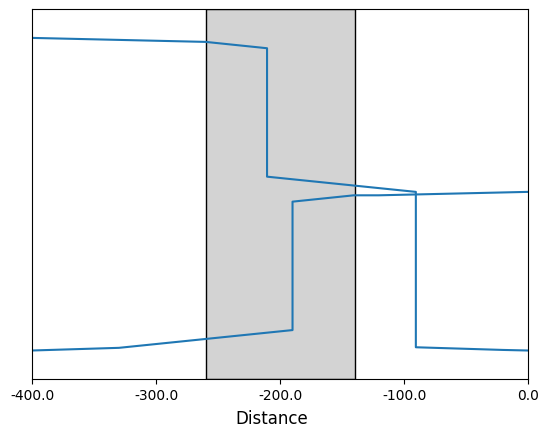

In [11]:
fig, axes = plt.subplots(1,1)
ylim = (vessel_df.iloc[0]['Time'],vessel_df.iloc[-1]['Time'])
lock_I.create_time_distance_diagram(vessels,ax=axes,x_offset=-200,accuracy=200,ylim=ylim)
# lock_II.create_time_distance_diagram([vessel],ax=axes[1],x_offset=200,accuracy=200,ylim=ylim)
axes.set_xlabel('')
axes.set_yticks([])
axes.set_xlabel('')
axes.set_ylabel('')
ylim = (vessel_df.iloc[0]['Time'],vessel_df.iloc[-1]['Time'])
plt.subplots_adjust(wspace=0)
fig.supxlabel('Distance');

And we can analyse the logbook of the lock

In [12]:
lock_df = pd.DataFrame(lock_I.log)
lock_df

,Time,Location,Action,Status
0,2024-01-01 00:09:31.394354,B,Lock doors closing start,{'visiting_vessels': [<__main__.Vessel object ...
1,2024-01-01 00:09:31.394354,B,Lock doors closing stop,{'visiting_vessels': [<__main__.Vessel object ...
2,2024-01-01 00:09:31.394354,B,Lock chamber converting start,{'visiting_vessels': [<__main__.Vessel object ...
3,2024-01-01 00:34:31.394354,C,Lock chamber converting stop,{'visiting_vessels': [<__main__.Vessel object ...
4,2024-01-01 00:34:31.394354,C,Lock doors opening start,{'visiting_vessels': [<__main__.Vessel object ...
5,2024-01-01 00:34:31.394354,C,Lock doors opening stop,{'visiting_vessels': [<__main__.Vessel object ...
6,2024-01-01 00:39:23.246206,C,Lock doors closing start,{'visiting_vessels': [<__main__.Vessel object ...
7,2024-01-01 00:39:23.246206,C,Lock doors closing stop,{'visiting_vessels': [<__main__.Vessel object ...
8,2024-01-01 00:39:23.246206,C,Lock chamber converting start,{'visiting_vessels': [<__main__.Vessel object ...
9,2024-01-01 01:04:23.246206,B,Lock chamber converting stop,{'visiting_vessels': [<__main__.Vessel object ...
